# Documentation

```python
#Call to read data and perfom initial clustering
class SuperCluster:

    #Initialisation with fingerprint parameters. Automatically calls MakeMorganFingerprints()
    __init__(self, file, MorganRadius=2, nBits=1024, ConsiderAtoms="Yes", useBondTypes=True)

    #Automatically called on instantiation. Fingerprint made for each molecule in dataset.
    MakeMorganFingerprints(self)

    #Create distance matrix using Morgan fingerprints
    MakeTanimotoDistanceMatrix(self)
    
    #Clustering by butina cluster. Cutoff is the maximum dissimilarity by tanimoto distance. 
    MakeButinaClusters(self, cutoff=0.2)

    #Visualisation of centroids in 5*N grid (N >= 20).
    ShowButinaCentroids(self)

    #Visualisation of specific cluster, where ClusterNumber is the index of the cluster. 5*N grid (N >= 20).
    ShowCluster(self, ClusterNumber=0)

    #Prints total number of clusters, and sorted array of clusters (max 100) starting with largest
    GetClusterData(self)


#For analysis of individual clusters
class Cluster

    #SuperCluster object is passed in with ClusterNumber index of chosen cluster for analysis
    __init__(self, SuperCluster, ClusterNumber)
    
    #Visualisation of  cluster 5*N grid (N >= 20).
    ShowCluster(self)
    
    #Makes morgan fingerprints for each molecule in cluster using the same parameters of the SuperCluster
    #This is redundant and fingerprints could be obtained directly from SuperCluster,
    #however I haven't bothered to do so
    MakeMorganFingerprints(self)
    
    #Computes tanimoto distance matrix using morgan fingerprints.
    #Again, values could be obtained from SuperCluster, however not implemented.
    MakeTanimotoDistanceMatrix(self)
    
    #Visualises distance matrix as heat map Can choose. Options of matrix="Morgan" and matrix="LOMAP".
    ShowHeatMap(self, matrix="Morgan", vmin=0, vmax=1, xdim = 11/2, ydim=9/2)
    
    #Plots histogram of all distances within distance matrix. Options of matrix="Morgan" and matrix="LOMAP"
    #Vertical red line is average value of all distances in matrix
    ShowHistogram(self, matrix="Morgan")
    
    #Calculates LOMAP distance matrix of all molecules in cluster. AddHydrogens=True, there is no functionality of
    #AddHydrogens=False, and will probably delete
    #limit = 30 is the maximum number of molecules that LOMAP will be performed on. This prevents
    #Excessive calculations. Passing cluster larger than limit will return runtime error.
    MakeLomapDistanceMatrix(self, AddHydrogens=True, limit = 30)
    
    #Prints all paramters used in clustering process.
    #ClusterNumber, N, MorganRadius, nBits, ConsiderAtoms, useBondTypes, ButinaClusterCutoff, 
    ShowClusterData(self)
    
    #Heirarchical clustering of cluster. Displays dendrogram and grid of molecules,
    #with molecules listed in the same order as the dendrogram leaves. 
    #InvertValues=True. 1-LOMAP score gives distance matrix where 0 is good, 1 is bad.
    #Needed for heirarchical clustering.
    ShowDendrogramLOMAP(self, InvertValues=True)
   

#-----------------Main-----------------------------
#Initialise. Fingerprints calculated by default.
moon = SuperCluster(moonshot_file, MorganRadius=4, ConsiderAtoms="No")
#Make distance matrix using fingerprints
moon.MakeTanimotoDistanceMatrix()
#Obtain Butina clusters
moon.MakeButinaClusters(cutoff = 0.2)



#------Morgan-------
#Create cluster object with cluster index 137. That is ButinaClusters[137]
#Must pass in SuperClass object
cluster = Cluster(moon, 137)
#Prints length of data and largest clusters
cluster.ShowClusterData()
#Plots histogram of tanimoto distances
cluster.ShowHistogram()
#Plots heatmap of distance matrix 
cluster.ShowHeatMap(vmin=0, vmax=1)


#------LOMAP-------
#Calculates LOMAP distance matrix. 
cluster.MakeLomapDistanceMatrix()

#Plots histogram of LOMAP distances
cluster.ShowHistogram(matrix="LOMAP")

#Plots heatmap of distance matrix
cluster.ShowHeatMap(vmin=0, vmax=1, matrix="LOMAP")

#Performs heirarchical clustering of molecules by (1-LOMAP) score and plots dendrogram.
#Molecules in cluster are shown as grid, in the same order as the dendrogram leaves
cluster.ShowDendrogramLOMAP()
```

# Imports
##### I have not tidied  this up yet. I have not even looked. So if I import the same thing 3x dont @ me.

In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

"""RDKit Bug
Dataframe can only be rendered once, and all subsequent renders give only string
Solution: Code below
Bug has been reported: https://github.com/rdkit/rdkit/issues/5017
"""
from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))


#Code below was copy and pasted for draw mol grid
import os
import copy
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdDepictor, rdMolDraw2D
opts = Draw.DrawingOptions()
Draw.SetComicMode(opts)


#################
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage



#LOMAP Scoring
import lomap
from rdkit.Chem import AllChem
import time

from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
def computeLOMAPScore(lig1, lig2):
    #Computes the LOMAP score for two input ligands, see https://github.com/OpenFreeEnergy/Lomap/blob/main/lomap/mcs.py.
    #Previously was _AllChem. Now AllChem.
    AllChem.EmbedMolecule(lig1, useRandomCoords=True)
    AllChem.EmbedMolecule(lig2, useRandomCoords=True)
    
    #This is a fudge. Not sure how to vary time out. Timing out raises error and breaks everything.
    #In this case, if timeout reached set mcsr = 0
    try:
        #Time = timout time
        MC = lomap.MCS(lig1, lig2, verbose=None, time=40)
    except:
        print("MC ERROR")
        return -0.05
    # # Rules calculations
    mcsr = MC.mcsr()
    strict = MC.tmcsr(strict_flag=True)
    loose = MC.tmcsr(strict_flag=False)
    mncar = MC.mncar()
    atnum = MC.atomic_number_rule()
    hybrid = MC.hybridization_rule()
    sulf = MC.sulfonamides_rule()
    het = MC.heterocycles_rule()
    growring = MC.transmuting_methyl_into_ring_rule()
    changering = MC.transmuting_ring_sizes_rule()


    score = mncar * mcsr * atnum * hybrid
    score *= sulf * het * growring
    lomap_score = score*changering

    return lomap_score

In [3]:
class SuperCluster:
    """
    __init__(self, file, MorganRadius=2, nBits=1024, ConsiderAtoms="Yes", useBondTypes=True)
    MakeMorganFingerprints(self)
    MakeTanimotoDistanceMatrix(self)
    MakeButinaClusters(self, cutoff=0.2)
    ShowButinaCentroids(self)
    ShowCluster(self, ClusterNumber=0)
    GetClusterData(self)
    """
    def __init__(self, file, MorganRadius=2, nBits=1024, ConsiderAtoms="Yes", useBondTypes=True):
        self.df = pd.read_csv(moonshot_file)
        PandasTools.AddMoleculeColumnToFrame(self.df, "SMILES",'Molecule')
        
        self.MorganRadius = MorganRadius
        self.nBits = nBits
        self.ConsiderAtoms = ConsiderAtoms
        self.useBondTypes = useBondTypes
        
        self.ButinaClusterCutoff = None
        
        self.fps = self.MakeMorganFingerprints()
        self.nfps = len(self.fps)
                
        self.MorganDistanceMatrix = []
        
        self.ButinaClusters = []
    
       
    def MakeMorganFingerprints(self):
        """
        Input: Dataframe

        parameters:
        ConsiderAtoms
            True - fingerprint initialised with atomic numbers
            False - all atoms initialised with value 1
            Features - using RDKit built in features initialisation

        returns:
            list of fingerprints, in same order as dataframe
        """
        
        fps = []
        if self.ConsiderAtoms == "Yes":
            for mol in self.df["Molecule"]:
                m = mol
                fps.append(AllChem.GetMorganFingerprintAsBitVect(m,self.MorganRadius,self.nBits, useBondTypes=self.useBondTypes))

        elif self.ConsiderAtoms == "No":
            for mol in self.df["Molecule"]:
                m = mol
                fps.append(AllChem.GetMorganFingerprintAsBitVect(m,self.MorganRadius,self.nBits, invariants=[1]*m.GetNumAtoms(), useBondTypes=self.useBondTypes))

        elif self.ConsiderAtoms == "Features":
            for mol in self.df["Molecule"]:
                m = mol
                fps.append(AllChem.GetMorganFingerprintAsBitVect(m,self.MorganRadius,self.nBits, useFeatures=True, useBondTypes=self.useBondTypes))
        
        #self.fps = fps
        return fps
        
        
    def MakeTanimotoDistanceMatrix(self):
        """
        Input: List of fingerprints
        Returns: Tanimoto distance matrix and number of fingerprints
        """
        dists = []
        for i in range(1,self.nfps):
            sims = DataStructs.BulkTanimotoSimilarity(self.fps[i],self.fps[:i])
            dists.extend([1-x for x in sims])

        self.MorganDistanceMatrix = dists

        return
    
    def MakeButinaClusters(self, cutoff=0.2):
        """
        Input: distance matrix, number of fingerprints, cutoff, isDistData
        Output: tuple of tuples, where each subtuple is a cluster, and the [0] position is the butina centroid
        """
        self.ButinaClusterCutoff = cutoff
        self.ButinaClusters = Butina.ClusterData(self.MorganDistanceMatrix,self.nfps,cutoff,isDistData=True)
        return
    
    def ShowButinaCentroids(self):
        centroids = []
        for cluster in self.ButinaClusters:
            centroids.append(cluster[0])

        print(f"Centroids (N = {len(centroids)})")
        ClusterToShow = self.df.iloc[centroids]
        return Draw.MolsToGridImage(ClusterToShow["Molecule"], molsPerRow=5, legends=list(ClusterToShow["CID"]))
    
        
    def ShowCluster(self, ClusterNumber=0):
        ClusterToShow = self.df.iloc[list(self.ButinaClusters[ClusterNumber])]
        
        #Could make lambda function
        counter = 0
        for cluster in self.ButinaClusters:
            if len(cluster) > 1:
                counter += 1
        print(f"Total number of clusters (N = {len(self.ButinaClusters)})\nNumber of clusters larger than 1 (N = {counter})\nShowing cluster number {ClusterNumber} (N = {len(ClusterToShow)})")
        return Draw.MolsToGridImage(ClusterToShow["Molecule"], molsPerRow=5, legends=list(ClusterToShow["CID"]))


    def GetClusterData(self):
        NumberOfClusters = len(self.ButinaClusters)
        ArrayOfClusterSizes = []
        counter = 0
        for x in self.ButinaClusters:
            ArrayOfClusterSizes.append((counter,(len(x))))
            counter += 1
        
        ArrayOfClusterSizes.sort(key=lambda tup: tup[1], reverse=True)
        
        print("NumberOfClusters ", NumberOfClusters)
        print("ArrayOfClusterSizes", ArrayOfClusterSizes[:100])

        return
    


class Cluster:
    """
    __init__(self, SuperCluster, ClusterNumber)
    ShowCluster(self)
    MakeMorganFingerprints(self)
    MakeTanimotoDistanceMatrix(self)
    ShowHeatMap(self, matrix="Morgan", vmin=0, vmax=1, xdim = 11/2, ydim=9/2)
    ShowHistogram(self, matrix="Morgan")
    MakeLomapDistanceMatrix(self, AddHydrogens=True)
    ShowClusterData(self)
    ShowDendrogramLOMAP(self, InvertValues=True)
    """
    def __init__(self, SuperCluster, ClusterNumber):
        self.ClusterNumber = ClusterNumber
        self.WholeCluster = list(SuperCluster.ButinaClusters[self.ClusterNumber])
        
        self.df = SuperCluster.df
        self.subset_df = SuperCluster.df.iloc[self.WholeCluster]
        
        self.N = len(self.WholeCluster)
        
        self.Centroid = self.WholeCluster[0]
        self.RemainingCluster = self.WholeCluster[1:]
        
        self.MorganRadius = SuperCluster.MorganRadius
        self.nBits = SuperCluster.nBits
        self.ConsiderAtoms = SuperCluster.ConsiderAtoms
        self.useBondTypes = SuperCluster.useBondTypes
        
        self.ButinaClusterCutoff = SuperCluster.ButinaClusterCutoff
        
        self.fps = self.MakeMorganFingerprints()
        self.nfps = len(self.fps)
        
        self.MorganDistanceMatrix = self.MakeTanimotoDistanceMatrix()
        self.LOMAPDistanceMatrix = []
    
    
    def ShowCluster(self):
        ClusterToShow = self.subset_df
        return Draw.MolsToGridImage(ClusterToShow["Molecule"], molsPerRow=5, legends=list(ClusterToShow["CID"]))
    
    def MakeMorganFingerprints(self):
        fps = []
        if self.ConsiderAtoms == "Yes":
            for mol in self.subset_df["Molecule"]:
                m = mol
                fps.append(AllChem.GetMorganFingerprintAsBitVect(m,self.MorganRadius,self.nBits, useBondTypes=self.useBondTypes))

        elif self.ConsiderAtoms == "No":
            for mol in self.subset_df["Molecule"]:
                m = mol
                fps.append(AllChem.GetMorganFingerprintAsBitVect(m,self.MorganRadius,self.nBits, invariants=[1]*m.GetNumAtoms(), useBondTypes=self.useBondTypes))

        elif self.ConsiderAtoms == "Features":
            for mol in self.subset_df["Molecule"]:
                m = mol
                fps.append(AllChem.GetMorganFingerprintAsBitVect(m,self.MorganRadius,self.nBits, useFeatures=True, useBondTypes=self.useBondTypes))
        return fps
    
    def MakeTanimotoDistanceMatrix(self):
        dists = []
        for i in range(1,self.nfps):
            sims = DataStructs.BulkTanimotoSimilarity(self.fps[i],self.fps[:i])
            dists.extend([1-x for x in sims])
        return dists
        
        
    def ShowHeatMap(self, matrix="Morgan", vmin=0, vmax=1, xdim = 11/2, ydim=9/2):
        if matrix == "Morgan":
            square_dists = squareform(self.MorganDistanceMatrix)
        elif matrix == "LOMAP":
            square_dists = squareform(self.LOMAPDistanceMatrix)
            
        mask = np.triu(np.ones_like(square_dists, dtype=bool))
        f, ax = plt.subplots(figsize=(xdim, ydim))
        sns.heatmap(square_dists, vmin=vmin, vmax = vmax, mask=mask)
        plt.show()
        return
    
    def ShowHistogram(self, matrix="Morgan"):
        if matrix == "Morgan":
            plt.hist(self.MorganDistanceMatrix, density=True, bins=20)  # density=False would make counts
            plt.axvline(x=sum(self.MorganDistanceMatrix)/len(self.MorganDistanceMatrix), color="r")
        elif matrix == "LOMAP":
            plt.hist(self.LOMAPDistanceMatrix, density=True, bins=20)  # density=False would make counts
            plt.axvline(x=sum(self.LOMAPDistanceMatrix)/len(self.LOMAPDistanceMatrix), color="r")
            
        plt.xlabel(f'{matrix} Distance')
        plt.ylabel('Number')
        
    
    def MakeLomapDistanceMatrix(self, AddHydrogens=True, limit=30):
        N = self.nfps
        print("Estimated time to complete = ", round(2.3*((N*N - N)/2)/60, 2), " Minutes")

        start_time = time.time()

        if N>limit:
            raise RuntimeError (f'Dataset of {N} is too large to apply GetLomapDistanceMatrix(). Max = {limit}')
            return

        dists = []
        nmol = self.nfps

        calculation_counter = 0
        #For each row
        for i in range(1,nmol):
            if AddHydrogens:
                m1 = Chem.rdmolops.AddHs(self.subset_df.iloc[i]["Molecule"]) 
            else:
                m1 = self.subset_df.iloc[i]["Molecule"]
            print(i)

            sims = []
            for j in range(i):
                if AddHydrogens:
                    m2 = Chem.rdmolops.AddHs(self.subset_df.iloc[j]["Molecule"])
                else:
                    m2 = self.subset_df.iloc[j]["Molecule"]
                #This can be extend
                sims.append(computeLOMAPScore(m1, m2))
                calculation_counter += 1

            #Entend places into original array. Append makes array of arrays
            dists.extend([1-x for x in sims])


        end_time = time.time()
        time_elapsed = end_time - start_time
        print("Time elapsed = ", time_elapsed)
        print("Number of calculations = ", calculation_counter)
        print("Time per calculation = ", time_elapsed/calculation_counter)
        
        self.LOMAPDistanceMatrix = dists
        return
    
    def ShowClusterData(self):
        print(f"Cluster number = {self.ClusterNumber}, (N = {self.N}), morgan radius = {self.MorganRadius}, nBits = {self.nBits}, ConsiderAtoms = {self.ConsiderAtoms}, useBondTypes = {self.useBondTypes}, ButinaClusterCutoff = {self.ButinaClusterCutoff}")
        #(self.N, self.MorganRadius, self.nBits, self.ConsiderAtoms, self.useBondTypes)
        return
    
    def ShowDendrogramLOMAP(self, InvertValues=True):
        
        if not InvertValues:
            print("No Functionality for this yet")
            
        inverted = [1-x for x in self.LOMAPDistanceMatrix]
        Z = linkage(inverted, 'average', optimal_ordering=True)
        dn = dendrogram(Z)

        indices_str = [str(x) for x in dn["leaves"]]
        indices = [self.WholeCluster[idx] for idx in dn["leaves"]]

        return Draw.MolsToGridImage(self.df.iloc[indices]["Molecule"], molsPerRow=5, legends=list(indices_str))

# Initialisation of clusters

In [4]:
moonshot_file = "Moonshot/COVID_moonshot_submissions/covid_submissions_all_info.csv"

#SuperCluster(file, MorganRadius=2, nBits=1024, ConsiderAtoms="Yes", useBondTypes=True)
print("Initialising")
moon = SuperCluster(moonshot_file, MorganRadius=4, ConsiderAtoms="No")
print("Making Distance Matrix")
moon.MakeTanimotoDistanceMatrix()
print("Clustering")
moon.MakeButinaClusters(cutoff = 0.2)
print("Done")

Initialising


/tmp/ipykernel_22765/3437489165.py:12: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(moonshot_file)
[21:41:31] WARNING: not removing hydrogen atom without neighbors
[21:41:31] WARNING: not removing hydrogen atom without neighbors


Making Distance Matrix
Clustering
Done


# Visualising cluster, and clustering paramters

Cluster number = 137, (N = 13), morgan radius = 4, nBits = 1024, ConsiderAtoms = No, useBondTypes = True, ButinaClusterCutoff = 0.2


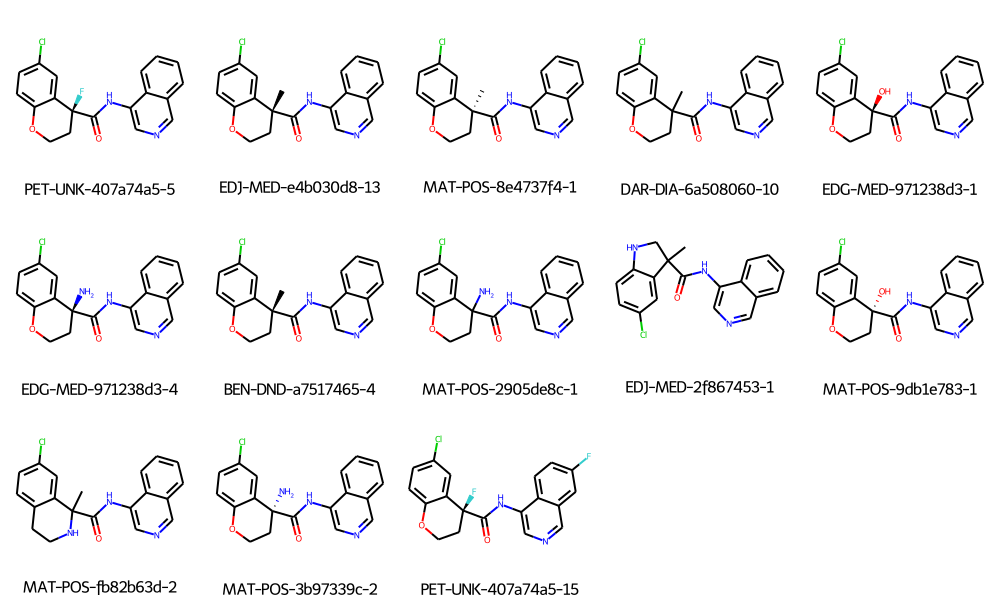

In [5]:
cluster = Cluster(moon, 137)
cluster.ShowClusterData()
cluster.ShowCluster()

# Histogram and Heatmap of Tanimoto Distances

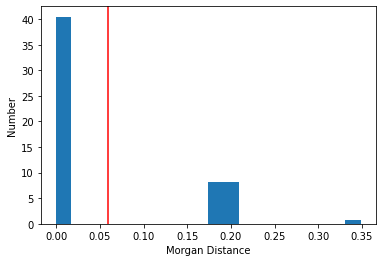

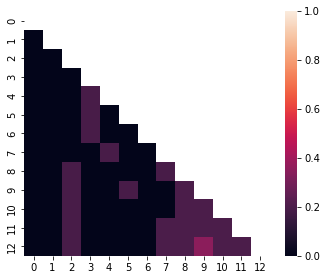

In [6]:
cluster.ShowHistogram()
cluster.ShowHeatMap(vmin=0, vmax=1, matrix="Morgan")

# Calculating LOMAP Distance Matrix

In [7]:
cluster.MakeLomapDistanceMatrix()

INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000


Estimated time to complete =  2.99  Minutes
1
2


INFO:	MCSR from MCS size 13, molecule sizes 25,25 is 0.090718
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 13, molecule sizes 25,25 is 0.090718
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000


3


INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 misma

4


INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 13, molecule sizes 25,25 is 0.090718
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25

5


INFO:	MCSR from MCS size 13, molecule sizes 25,25 is 0.090718
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 misma

6


INFO:	MCSR from MCS size 13, molecule sizes 25,25 is 0.090718
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 misma

7


INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25

8


INFO:	MCSR from MCS size 14, molecule sizes 24,25 is 0.122456
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	tRansforming ring sizes score is 0 based on atom 1 in moli and 13 in molj
INFO:	tRansforming ring sizes score is 0 based on atom 1 in moli and 13 in molj
INFO:	MCSR from MCS size 14, molecule sizes 24,25 is 0.122456
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	tRansforming ring sizes score is 0 based on atom 1 in moli and 1 in molj
INFO:	tRansforming ring sizes score is 0 based on atom 1 in moli and 1 in molj
INFO:	MCSR from MCS size 14, molecule sizes 24,25 is 0.122456
INFO:	atomic number 

9


INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 13, molecule sizes 25,25 is 0.090718
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 13, molecule sizes 25,25 is 0.090718
INFO:	atomic number score from 0 misma

10


INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 1 mismatches is 0.904837
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 1 mismatches is 0.904837
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 1 mismatches is 0.860708
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR

11


INFO:	MCSR from MCS size 13, molecule sizes 25,25 is 0.090718
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 25,25 is 1.000000
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 13, molecule sizes 25,25 is 0.090718
INFO:	atomic number score from 0 misma

12


INFO:	MCSR from MCS size 13, molecule sizes 26,25 is 0.082085
INFO:	atomic number score from 0 mismatches is 1.000000
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 26,25 is 0.904837
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 26,25 is 0.904837
INFO:	atomic number score from 0 mismatches is 0.951229
INFO:	hybridization score from 0 mismatches is 1.000000
INFO:	sulfonamide score is 1.000000
INFO:	heterocycle score is 1.000000
INFO:	methyl-to-ring transformation score is 1.000000
INFO:	MCSR from MCS size 25, molecule sizes 26,25 is 0.904837
INFO:	atomic number score from 0 misma

Time elapsed =  85.1399736404419
Number of calculations =  78
Time per calculation =  1.091538123595409


# Histogram and Heatmap of LOMAP distances

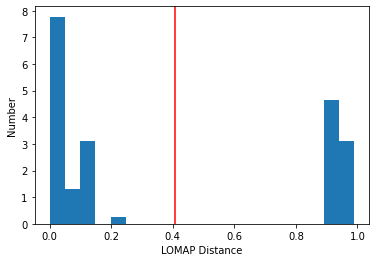

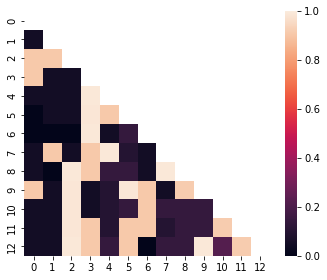

In [8]:
cluster.ShowHistogram(matrix="LOMAP")
cluster.ShowHeatMap(vmin=0, vmax=1, matrix="LOMAP")

# Heirarchical clustering of cluster by LOMAP score

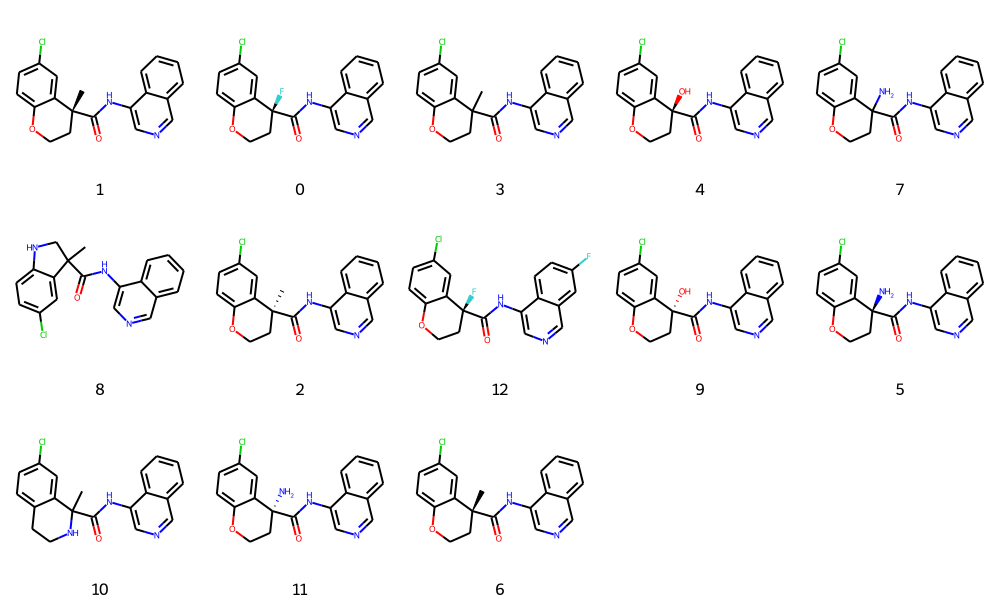

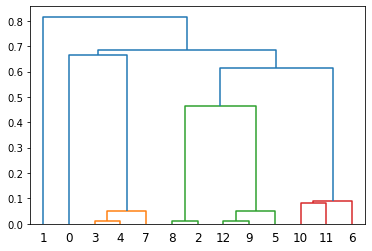

In [9]:
cluster.ShowCluster()
cluster.ShowDendrogramLOMAP()